# Dependence of Estimated Coefficients on Experimental Design

## Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

In [6]:
# packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from scipy.stats import weibull_min, beta, norm, kruskal, ttest_ind, mannwhitneyu
from scipy.optimize import root, root_scalar
from scipy.spatial.distance import pdist
from tqdm.notebook import tqdm
from lifelines import WeibullFitter
import scipy.stats as stats
import random
from scipy.stats import levene
import pickle
import statsmodels.api as sm


# BIC

def BIC(density, n_coefs, debug_eps = 1e-10):
    return -2*np.sum(np.log(density + debug_eps)) + n_coefs*np.log(len(density))

# g density function

def g_density_function(data, t_0, weights, shape_k, lambda_scale, n_comp):
    g_den = weights[0] * \
            weibull_min.pdf(data['D']*(data['T'] - t_0[0]), \
                            c = shape_k[0], \
                            scale = lambda_scale[0])
    for i in range(1,n_comp):
        g_den = g_den + weights[i] * \
             weibull_min.pdf(data['D']*(data['T'] - t_0[i]), \
                             c = shape_k[i], \
                             scale = lambda_scale[i])
    return g_den

def g_density_function_2(data, weights, shape_k, lambda_scale, n_comp):
    g_den = weights[0] * \
            weibull_min.pdf(data, \
                            c = shape_k[0], \
                            scale = lambda_scale[0])
    for i in range(1,n_comp):
        g_den = g_den + weights[i] * \
             weibull_min.pdf(data, \
                             c = shape_k[i], \
                             scale = lambda_scale[i])
    return g_den

  # optimization function

def f_weibull(D, T, scale_lambda, shape_k, t_0):
    ret = weibull_min.pdf(D*(T - t_0), c = shape_k, scale = scale_lambda)
    return ret + 1e-100

def log_f_weibull(D, T, scale_lambda, shape_k, t_0):
    ret = weibull_min.logpdf(D*(T - t_0), c = shape_k, scale = scale_lambda)
    return np.maximum(ret, 1e-10)

def d_f_weibull_scale_lambda(D, T, scale_lambda, shape_k, t_0):
    ret = -((shape_k**2)*(np.exp(-((D*(T - t_0))/scale_lambda)**shape_k))*(((D*(T - t_0))/scale_lambda)**shape_k)*((((D*(T - t_0))/scale_lambda)**shape_k) - 1))/(D*(T - t_0)*scale_lambda)
    return ret + 1e-100

def d_f_weibull_shape_k(D, T, scale_lambda, shape_k, t_0):
    ret = (np.exp(-((D*(T - t_0))/scale_lambda)**shape_k))*(((D*(T - t_0))/scale_lambda)**shape_k)*(shape_k*((((D*(T - t_0))/scale_lambda)**shape_k)-1)*np.log(((D*(T - t_0))/scale_lambda) - 1))/(D*(t_0 - T))
    return ret + 1e-100

def d_f_weibull_t_0(D, T, scale_lambda, shape_k, t_0):
    ret = shape_k*(np.exp(-((D*(T - t_0))/scale_lambda)**shape_k))*(((D*(T - t_0))/scale_lambda)**shape_k)*(shape_k*(((D*(T - t_0))/scale_lambda)**shape_k) - shape_k + 1)/(D*(t_0 - T)**2)
    return ret + 1e-100

# actual algorithm

def EM_function(data, epsilon = 1e-06, n_comp = 2, debug_eps = 1e-10, lower_t_0 = 9, upper_t_0 = 11, emergency_stop = 1000):

    n = len(data)

    dt = data.copy()

    #pre_candidates_t_0 = random.choices(np.arange(lower_t_0, upper_t_0, 0.01), k=n_comp)
    #pre_labels = random.choices(list(range(1, 5)), k=n_comp)
    #pre_labels = np.array(pre_labels)
    #weights = pre_labels / np.sum(pre_labels)



    dt['__original_order__'] = range(n)
    dt['sort_key'] = dt['D'] * dt['T']
    dt = dt.sort_values(by='sort_key')
    dt = dt.drop(columns='sort_key')

    if n_comp == 1:
      pre_candidates_t_0 = [(lower_t_0 + upper_t_0) / 2]
      weights = [1]
      w1 = pre_candidates_t_0[0]
      split_index = int(weights[0] * n)
      dt['candidates_t_0'] = [w1]*split_index
    elif n_comp == 2:
      pre_candidates_t_0 = [lower_t_0, upper_t_0]
      weights = [0.6, 0.4]
      w1 = pre_candidates_t_0[0]
      w2 = pre_candidates_t_0[1]
      split_index = int(weights[0] * n)
      dt['candidates_t_0'] = [w1]*split_index + [w2]*(n - split_index)
    elif n_comp == 3:
      pre_candidates_t_0 = [lower_t_0, (lower_t_0 + upper_t_0) / 2, upper_t_0]
      weights = [0.4, 0.3, 0.3]
      w1 = pre_candidates_t_0[0]
      w2 = pre_candidates_t_0[1]
      w3 = pre_candidates_t_0[2]
      split_index = int(weights[0] * n)
      split_index2 = int(weights[1] * n)
      dt['candidates_t_0'] = [w1]*split_index + [w2]*split_index2 + [w3]*(n - split_index - split_index2)
    elif n_comp == 4:
      m_t_0 = (lower_t_0 + upper_t_0) / 2
      q1_t_0 = (lower_t_0 + m_t_0) / 2
      q2_t_0 = (m_t_0 + upper_t_0) / 2
      pre_candidates_t_0 = [lower_t_0, q1_t_0, q2_t_0, upper_t_0]
      weights = [0.25, 0.25, 0.25, 0.25]
      w1 = pre_candidates_t_0[0]
      w2 = pre_candidates_t_0[1]
      w3 = pre_candidates_t_0[2]
      w4 = pre_candidates_t_0[3]
      split_index = int(weights[0] * n)
      split_index2 = int(weights[1] * n)
      split_index3 = int(weights[2] * n)
      dt['candidates_t_0'] = [w1]*split_index + [w2]*split_index2 + [w3]*split_index3 + [w4]*(n - split_index - split_index2 - split_index3)

    dt = dt.sort_values(by='__original_order__').drop(columns='__original_order__')

    dt['k'] = dt['D'] * (dt['T'] - dt['candidates_t_0'])


    scale_lambda = []
    shape_k = []
    t_0 = pre_candidates_t_0

    for position in pre_candidates_t_0:
        group_from_dt = dt[dt['candidates_t_0'] == position]['k']
        shape1, loc1, scale1 = weibull_min.fit(group_from_dt, floc=0)
        scale_lambda.append(scale1)
        shape_k.append(shape1)


    new_scale_lambda = scale_lambda
    new_shape_k = shape_k
    new_t_0 = t_0

#############################

    #new_scale_lambda = [298, 452]
    #new_shape_k = [8.5, 8.2]
    #new_t_0 = [8.9, 11.5]

#############################

    iter_step = 0
    convergence_criterion = False
    Q_function = float('-inf')
    Q_function_trace = []
    cont_cor = 10

    while not convergence_criterion:

        if iter_step % 100 == 0:
            print('Please wait... (' + str(iter_step) + f', {cont_cor})')

        # E step

        v = np.random.rand(n,n_comp)
        for i in range(n_comp):
            v[:,i] = np.log(weights[i] + debug_eps) + log_f_weibull(dt['D'], dt['T'], scale_lambda[i], shape_k[i], t_0[i])

        for i in range(n):
            v[i,:] = np.exp(v[i,:] - np.max(v[i,:])) / np.sum(np.exp(v[i,:] - np.max(v[i,:])))
            v[i,:] = v[i,:] + debug_eps

        # M step

        ## weights

        #weights_new = np.random.rand(n_comp)

        #for i in range(n_comp - 1):
        #    raw_weight = (np.sum(v[:, i]) / np.sum(v[:, (n_comp - 1)] + v[:, i])) * (1 - np.sum(weights[:-1]) + weights[i])
        #    weights_new[i] = max(raw_weight, 0.1)
        #weights_new[-1] = max(1 - np.sum(weights_new[:-1]), 0.1)
        #weights = weights_new / np.sum(weights_new)

        weights_new = np.sum(v, axis=0) / n
        weights = weights_new


        ## t_0

        for i in range(n_comp):
            t_0_opt_function = lambda y: np.sum((v[:,i] / \
                                                f_weibull(D = dt['D'],
                                                          T = dt['T'],
                                                          scale_lambda = scale_lambda[i],
                                                          shape_k = shape_k[i],
                                                          t_0 = y)) * \
                                                d_f_weibull_t_0(D = dt['D'],
                                                                T = dt['T'],
                                                                scale_lambda = scale_lambda[i],
                                                                shape_k = shape_k[i],
                                                                t_0 = y))
            try:
              new_t_0[i] = root_scalar(t_0_opt_function, \
                                       bracket=[lower_t_0, upper_t_0],
                                       method='bisect').root
            except ValueError:
              new_t_0[i] = t_0[i]

            #new_t_0[i] = root(t_0_opt_function, \
            #                  x0 = np.mean([lower_t_0, upper_t_0])).x

        ## scales

        for i in range(n_comp):
            scale_opt_function = lambda y: np.sum((v[:,i] / \
                                                   f_weibull(D = dt['D'],
                                                             T = dt['T'],
                                                             scale_lambda = scale_lambda[i],
                                                             shape_k = shape_k[i],
                                                             t_0 = y)) * \
                                                  d_f_weibull_scale_lambda(D = dt['D'],
                                                                           T = dt['T'],
                                                                           scale_lambda = scale_lambda[i],
                                                                           shape_k = shape_k[i],
                                                                           t_0 = y))

            new_scale_lambda[i] = root(scale_opt_function,
                                       x0 = scale_lambda[i]).x

        ## shapes

        for i in range(n_comp):
            shape_opt_function = lambda y: np.sum((v[:,i] / \
                                                   f_weibull(D = dt['D'],
                                                             T = dt['T'],
                                                             scale_lambda = scale_lambda[i],
                                                             shape_k = shape_k[i],
                                                             t_0 = y)) * \
                                                  d_f_weibull_shape_k(D = dt['D'],
                                                                      T = dt['T'],
                                                                      scale_lambda = scale_lambda[i],
                                                                      shape_k = shape_k[i],
                                                                      t_0 = y))


            new_shape_k[i] = root(shape_opt_function, \
                                  x0 = shape_k[i]).x


        #if iter_step == 0:
        #  print("mean responsibilities (v):", np.mean(v, axis=0))
        ## check convergence

        shape_k = new_shape_k
        scale_lambda = new_scale_lambda
        t_0 = new_t_0


        Q_function_n = 0

        for i in range(0, n_comp):
            Q_function_n = Q_function_n +  np.sum(v[:,i]*(np.log(weights[i] + debug_eps) + log_f_weibull(D = dt['D'],
                                                                                                         T = dt['T'],
                                                                                                         scale_lambda = scale_lambda[i],
                                                                                                         shape_k = shape_k[i],
                                                                                                         t_0 = t_0[i])))


        if ((np.abs(Q_function - Q_function_n) < epsilon) or iter_step > emergency_stop):
            convergence_criterion = True
            if iter_step < 100:
              convergence_criterion = False

        cont_cor = np.abs(Q_function - Q_function_n)
        Q_function = Q_function_n
        Q_function_trace.append(Q_function)
        iter_step = iter_step + 1

        for i in range(n_comp):
            if weights[i] <= 0:
                weights[i] = debug_eps
            if shape_k[i] <= 0:
                shape_k[i] = debug_eps
            if scale_lambda[i] <= 0:
                scale_lambda[i] = debug_eps

    #if iter_step > emergency_stop:
    #    message = "Again!"
    #else:
    #    message = "Algorithm succeeded."

    message = '<no message>'

    BICs = BIC(g_density_function(dt,
                                  t_0,
                                  weights,
                                  shape_k,
                                  scale_lambda,
                                  n_comp),
               n_coefs = n_comp * 3)

    return {'t_0': t_0,
            'weights': weights,
            'shape': shape_k,
            'scale': scale_lambda,
            'message': message,
            'BIC': BICs,
            'trace': Q_function_trace,
            'steps': iter_step,
            'n_comp': n_comp}


def cluster(data, t_0, weights, shape_k, lambda_scale, n_comp, debug_eps = 1e-10):

    labels = []

    for i in range(len(data)):
        pre_labels = [weights[0] * \
                      weibull_min.pdf((data['D']*(data['T'] - t_0[0]))[i], \
                                      c = shape_k[0] + debug_eps, \
                                      scale = lambda_scale[0] + debug_eps)]
        for j in range(1,n_comp):
            pre_labels.append(weights[j] * \
                              weibull_min.pdf((data['D']*(data['T'] - t_0[j]))[i], \
                                              c = shape_k[j] + debug_eps, \
                                              scale = lambda_scale[j] + debug_eps))

        pre_labels = pre_labels / sum(pre_labels)
        pre_labels = pre_labels.tolist()
        labels.append(t_0[pre_labels.index(max(pre_labels))])


    return labels

epsilon = 1e-6

## Exploration

In [7]:
necrodes = pd.read_excel("second_project/Necrodes.xlsx")
creophilus = pd.read_excel("second_project/Creophilus.xlsx")

In [8]:
necrodes = necrodes[['TEMP.', 'TIME (D)']].rename(columns={
    "TEMP.": "T",
    "TIME (D)": "D"
})

creophilus = creophilus[['T', 'Total immature development']].rename(columns={
    "T": "T",
    "Total immature development": "D"
})

In [9]:
necrodes['DT'] = necrodes['D']*necrodes['T']

creophilus['DT'] = creophilus['D']*creophilus['T']

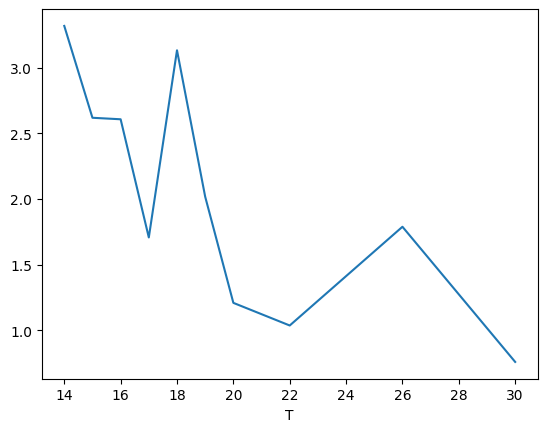

In [10]:
necrodes.groupby("T")["D"].std().plot()
plt.show()

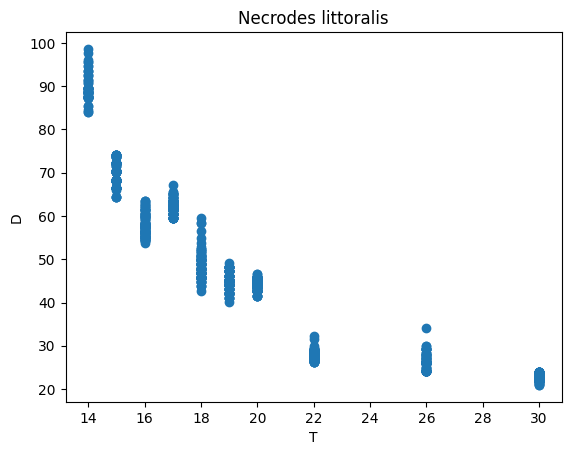

In [11]:
plt.scatter(necrodes["T"], necrodes["D"])
plt.xlabel("T")
plt.ylabel("D")
plt.title("Necrodes littoralis")
plt.show()

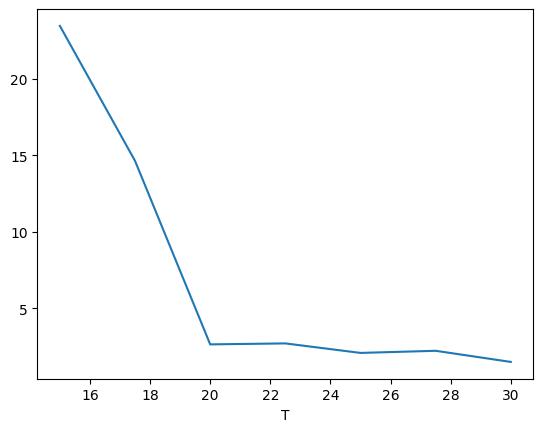

In [12]:
creophilus.groupby("T")["D"].std().plot()
plt.show()

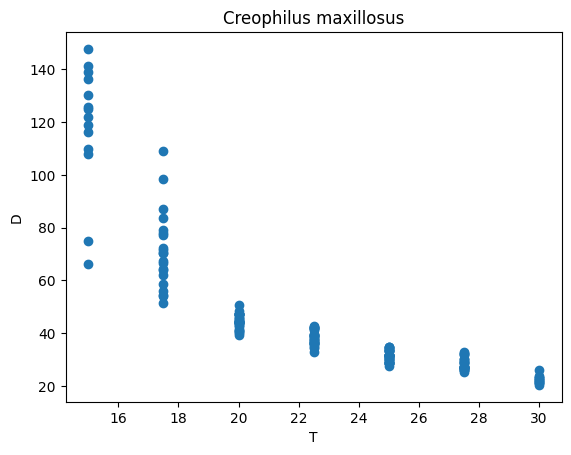

In [13]:
plt.scatter(creophilus["T"], creophilus["D"])
plt.xlabel("T")
plt.ylabel("D")
plt.title("Creophilus maxillosus")
plt.show()

## Simulation

In [14]:
k = 400
t = 8

# k = D(T - t)
# D = k/(T - t)

T1 = np.array([10, 14, 22, 25, 33, 35])
T2 = np.array([18, 21, 22, 25, 26, 27])

std1 = -0.36*T1 + 13.6
std2 = -0.36*T2 + 13.6

mu1 = k/(T1 - 8)
mu2 = k/(T2 - 8)

df_T1 = pd.DataFrame({'D': [], 'T': []})

for i in range(6):
    df1 = pd.DataFrame({'T': [T1[i]]*100,
                       'D': np.random.normal(loc=mu1[i], scale=std1[i], size=100)})
    
    df_T1 = pd.concat([df_T1, df1], ignore_index = True)
    
df_T2 = pd.DataFrame({'D': [], 'T': []})

for i in range(6):
    df1 = pd.DataFrame({'T': [T2[i]]*100,
                       'D': np.random.normal(loc=mu2[i], scale=std2[i], size=100)})
    
    df_T2 = pd.concat([df_T2, df1], ignore_index = True)

df_T1['DT'] = df_T1['D']*df_T1['T']
df_T2['DT'] = df_T2['D']*df_T2['T']

In [16]:
df_T1_calc = df_T1.groupby("T", as_index=False)["D"].median()
df_T1_calc['DT'] = df_T1_calc['D']*df_T1_calc['T']
#df_T1_calc = df_T1

x = df_T1_calc["D"].to_numpy()
y = df_T1_calc["DT"].to_numpy()

stdT1 = T1.std()

r = np.corrcoef(x, y)[0, 1]
slope = np.sign(r) * (np.std(y, ddof=1) / np.std(x, ddof=1))
intercept = np.mean(y) - slope * np.mean(x)

print(f"RMA t: {slope}, k: {intercept}, stdT1: {stdT1}")

RMA t: 7.978408643365325, k: 403.7328143000172, stdT1: 9.118052911059952


In [1]:
9.118052911059952**2

83.13888888888886

In [18]:
df_T2_calc = df_T2.groupby("T", as_index=False)["D"].median()
df_T2_calc['DT'] = df_T2_calc['D']*df_T2_calc['T']
#df_T2_calc = df_T2

x = df_T2_calc["D"].to_numpy()
y = df_T2_calc["DT"].to_numpy()

stdT2 = T2.std()

r = np.corrcoef(x, y)[0, 1]
slope = np.sign(r) * (np.std(y, ddof=1) / np.std(x, ddof=1))
intercept = np.mean(y) - slope * np.mean(x)

print(f"RMA t: {slope}, k: {intercept}, stdT2: {stdT2}")

RMA t: 7.5209934777443985, k: 413.9964128867348, stdT2: 3.131382371342656


In [2]:
3.131382371342656**2

9.805555555555555

In [104]:
EM_function(df_T2, epsilon=epsilon, n_comp=1, lower_t_0 = 7, upper_t_0 = 9, emergency_stop = 1000)

Please wait... (0, 10)


/Users/ww.jedrzej/miniconda3/envs/ncn/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Please wait... (100, 0.0)


{'t_0': [8.43171261727366],
 'weights': array([1.]),
 'shape': [array([13.17399474])],
 'scale': [array([426.33478465])],
 'message': '<no message>',
 'BIC': 7915.982304754485,
 'trace': [1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999

In [109]:
gamma(1 + 1/13.17399474)*426.33478465

409.9283331780106

In [105]:
EM_function(df_T1, epsilon=epsilon, n_comp=1, lower_t_0 = 7, upper_t_0 = 9, emergency_stop = 1000)

Please wait... (0, 10)


/Users/ww.jedrzej/miniconda3/envs/ncn/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Please wait... (100, 0.0)


{'t_0': [8.113421670042953],
 'weights': array([1.]),
 'shape': [array([12.67067007])],
 'scale': [array([423.58030657])],
 'message': '<no message>',
 'BIC': 7017.566372067241,
 'trace': [1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.7999987670808156e-07,
  1.799

In [110]:
gamma(1 + 1/12.67067007)*423.58030657

406.71948920116546

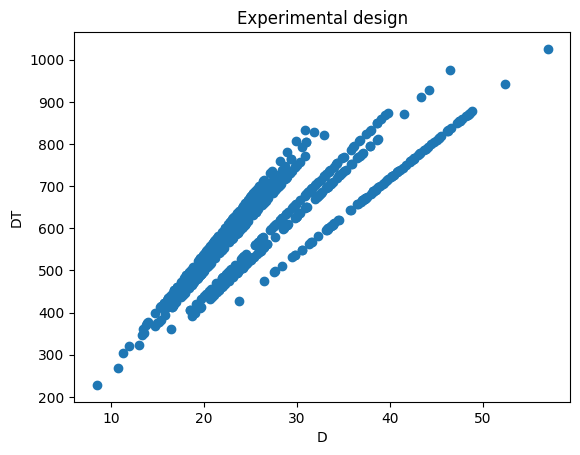

In [22]:
plt.scatter(df_T2["D"], df_T2["DT"])
plt.xlabel("D")
plt.ylabel("DT")
plt.title("Experimental design")
plt.show()